In [1]:
%load_ext autoreload
%autoreload 2

## Images to Vectors 

In [2]:
import os
import re

import numpy as np
import pandas as pd
from sklearn import preprocessing
from tqdm.auto import tqdm

from meezer.helpers import Img2Vec

In [3]:
input_path = '/meezer/data/A_Bean_for_Halloween'
files = os.listdir(input_path)

In [4]:
img2vec = Img2Vec()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
test_image = os.path.join(input_path, files[0])
vec = img2vec.get_vec(test_image)

vec_length = vec.shape[0]

In [6]:
# Matrix to hold the image vectors
X = np.zeros((len(files), vec_length))

print('Reading images...')
for index, file in tqdm(enumerate(files)):
    filename = os.fsdecode(file)
    vec = img2vec.get_vec(os.path.join(input_path, filename))
    X[index, :] = vec

Reading images...


In [7]:
reg_ex_pat = r'([^/]+)_\d+.jpeg$'

cleaned_filenames = [re.findall(reg_ex_pat, filename)[0] for filename in files]

In [8]:
le = preprocessing.LabelEncoder()

labels = le.fit_transform(cleaned_filenames)

In [9]:
pd.Series(labels).value_counts()

3     120
9     118
1      94
11     54
4      45
10     43
5      36
2      27
0      24
6      21
8       8
7       7
dtype: int64

## Test Data Split 

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    labels,
                                                    stratify=labels,
                                                    test_size=0.1,
                                                    random_state=42)

## Train a Model 

In [12]:
from meezer import Meezer

In [14]:
model = Meezer(embedding_dims=2,
               k=10,
               distance='pn',
               batch_size=64,
               epochs=10,
               sub_epochs=10,
               margin=1,
               ntrees=50,
               search_k=-1,
               model='maaten',
               supervision_metric='sparse_categorical_crossentropy',
               supervision_weight=0.25,
               annoy_index_path='annoy.index',
               early_stopping=True,
               reduce_lr_amount=0.95,
               verbose=True)

In [15]:
model.hard_mode = False

In [16]:
embeddings = model.fit_transform(X=X_train, Y=y_train)

Building KNN index...



Extracting KNN from index...



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Training neural network...


Epoch 0: loss 0.9094151358919659
New learning rate set to: 0.0009500000160187483
Building new KNN index...
Extracting KNN from new index...
Training next epoch...
Epoch 1: loss 0.30376849235408354
New learning rate set to: 0.0009025000035762787
Building new KNN index...
Extracting KNN from new index...
Training next epoch...
Epoch 2: loss 0.1952387231605013
New learning rate set to: 0.0008573749801144004
Building new KNN index...
Extracting KNN from new index...
Training next epoch...
Epoch 3: loss 0.13813932075250196
New learning rate set to: 0.0008145062020048499
Building new KNN index...
Extracting KNN from new index...
Training next epoch...
Epoch 4: loss 0.0968632334368078
New learning rate set to: 0.000773780862800777
Building new KNN index...
Extracting KNN from new index...
Training next epoch...
Epoch 5: loss 0.08773429074031572
New learning rate set to: 0.0007350918021984398
Building new KNN index...
Extracting KNN from new index...
Training next epoch...
Epoch 6: loss 0.1358

In [17]:
test_embeddings = model.transform(X_test)

60/60 [==============================] - 0s 228us/sample


## Visualize Embeddings 

In [18]:
import matplotlib
import matplotlib.pyplot as plt

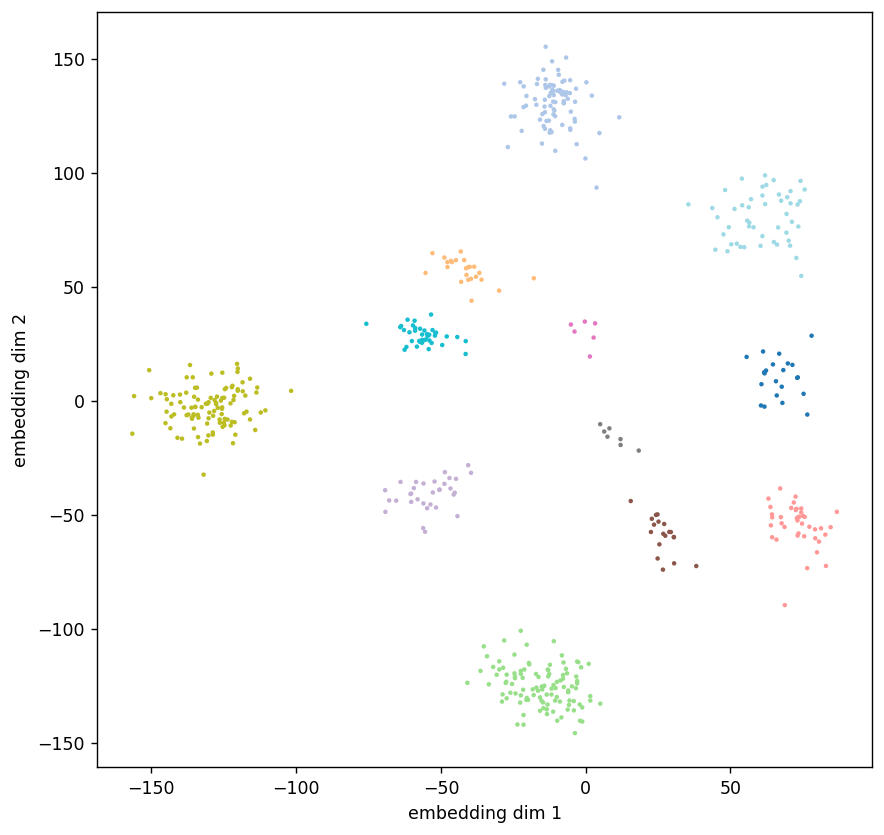

In [19]:
plt.figure(figsize=(8, 8), dpi=125)

plt.scatter(x=embeddings[:, 0],
            y=embeddings[:, 1],
            c=y_train,
            cmap='tab20',
            s=2.5)

plt.xlabel('embedding dim 1')
plt.ylabel('embedding dim 2')
plt.show()

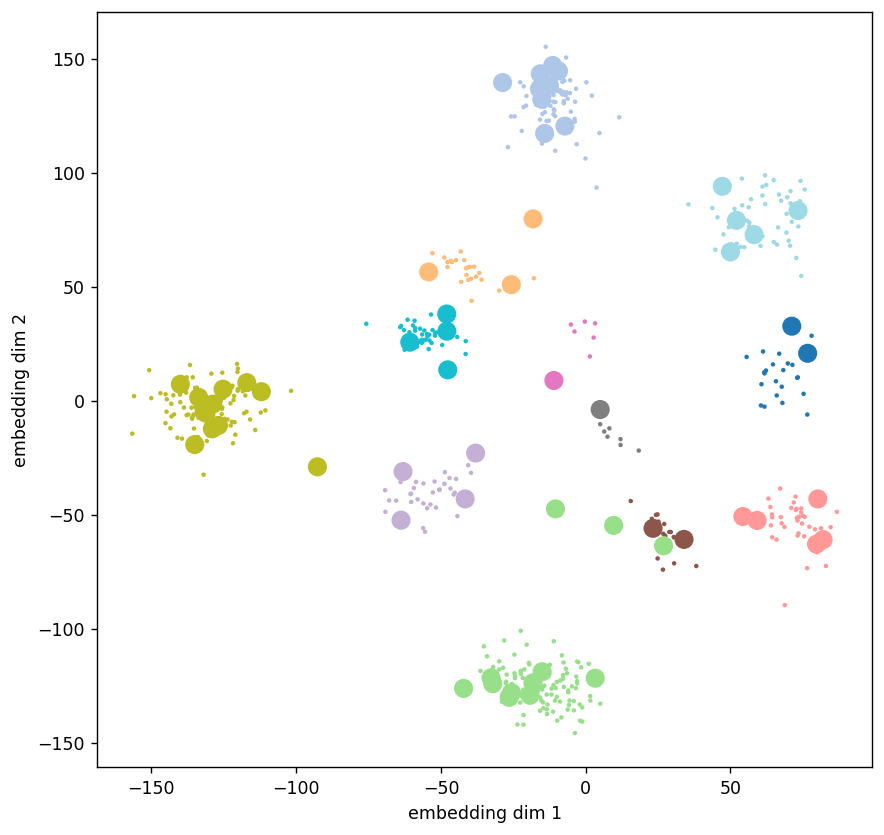

In [20]:
plt.figure(figsize=(8, 8), dpi=125)

plt.scatter(x=embeddings[:, 0],
            y=embeddings[:, 1],
            c=y_train,
            cmap='tab20',
            s=2.5)

plt.scatter(x=test_embeddings[:, 0],
            y=test_embeddings[:, 1],
            c=y_test,
            cmap='tab20',
            s=100)
plt.xlabel('embedding dim 1')
plt.ylabel('embedding dim 2')
plt.show()

## Evaluate 

In [21]:
test_scores = model.score_samples(X_train)
preds = np.argmax(test_scores, axis=1)

537/537 [==============================] - 0s 742us/sample


In [22]:
from sklearn.metrics import accuracy_score

In [23]:
accuracy_score(y_train, preds)

0.9739292364990689

In [24]:
test_scores = model.score_samples(X_test)
preds = np.argmax(test_scores, axis=1)

60/60 [==============================] - 0s 251us/sample


In [25]:
from sklearn.metrics import accuracy_score

In [26]:
accuracy_score(y_test, preds)

0.9166666666666666